<h1>Моделирование прогноза температуры льда на основе простой нейронной сети</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime as dt
from datetime import datetime
from dotenv import load_dotenv
from clickhouse_driver import Client

import sys
from tqdm import tqdm

plt.style.use('dark_background')

In [2]:
load_dotenv()

HOST = os.getenv('ANALYTICAL_HOST')
USERNAME = os.getenv('USERNAME')
PASSWORD = os.getenv('ANALYTICAL_PASSWORD')
CA = os.getenv('CA')
READONLY = os.getenv('READONLY')

client = Client(host=HOST, user=USERNAME, password=PASSWORD, ca_certs=CA, secure=True)

In [3]:
df = client.query_dataframe(f'''
    SELECT time, temp_ice, temp_inside
    FROM akarmanov_test_db.genesis_arena_prediction_ice
''')

df[10000:50000].to_csv('../data/small_data.csv', index=False)
# df = pd.read_csv('../data/small_data.csv')

In [179]:
# df = pd.read_csv('../data/small_data.csv')

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

# Создание загрузчика данных

In [251]:
class TimeSeriesDataset(Dataset):
    def __init__(self, path, seq_length, step_size, split='train', train_size=0.7, val_size=0.15, scaler=None):
        '''
        Args:
            path (str): path to csv file with data
            seq_length (int): sequence length for input data
            step_size (int): steps count forward for prediction (horizon)
            split (str): type of sample ('train', 'val', 'test')
            train_size (float): data proportion for train sample
            val_size (float): data proportion for val sample -> test_size = 1 - train_size - val_size
            scaler (sklearn.preprocessing)
        '''
        
        self.features = ['temp_ice', 'temp_inside']
        self.data = pd.read_csv(path, usecols=['time'] + self.features)
        self.seq_length = seq_length
        self.step_size = step_size
        self.scaler = scaler

        # split train, validation and test sampling
        n = len(self.data)
        train_end = int(n * train_size)
        val_end = train_end + int(n * val_size)

        if split == 'train':
            self.data = self.data[:train_end]
            self.scaler = MinMaxScaler()
            self.scaler.fit(self.data[['temp_ice', 'temp_inside']])
    
        elif split == 'val':
            self.data = self.data[train_end:val_end]
        elif split == 'test':
            self.data = self.data[val_end:]
        else:
            raise ValueError('split must be "train", "val" or "test"')


        # define weights for loss function
        self.weights = self.data['temp_ice'].diff(1).fillna(0)**4
        self.weights = self.weights.values

        if self.scaler is not None:
            self.data[['temp_ice', 'temp_inside']] = self.scaler.transform(self.data[['temp_ice', 'temp_inside']])
        else:
            raise ValueError('Scaler not defined, create a train_dataset instance for it')
        

    def __len__(self):
        return len(self.data) - self.seq_length - self.step_size + 1
    

    def __getitem__(self, idx):
        x = self.data.iloc[idx: idx + self.seq_length][['temp_ice', 'temp_inside']].values
        y = self.data.iloc[idx + self.seq_length + self.step_size - 1]['temp_ice']
        w = self.weights[idx + self.seq_length + self.step_size - 1]

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), torch.tensor(w, dtype=torch.float32)
    

path = '../data/small_data.csv'
seq_length = 60
step_size = 30

train_dataset = TimeSeriesDataset(path, seq_length, step_size, split='train', train_size=0.7, val_size=0.15)
val_dataset = TimeSeriesDataset(path, seq_length, step_size, split='val', train_size=0.7, val_size=0.15, scaler=train_dataset.scaler)
test_dataset = TimeSeriesDataset(path, seq_length, step_size, split='test', train_size=0.7, val_size=0.15, scaler=train_dataset.scaler)

In [252]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [253]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Создание модели

In [254]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear_1 = nn.Linear(seq_length * 2, 128)
        self.linear_2 = nn.Linear(128, 32)
        self.linear_3 = nn.Linear(32, output_size)
        self.act = nn.ReLU()
    

    def forward(self, x):
        x = self.linear_1(x)
        x = self.act(x)
        x = self.linear_2(x)
        x = self.act(x)
        x = self.linear_3(x)

        return x


def weighted_mse_loss(pred_y, y, w):
    return (w*(pred_y - y)**2)


model = SimpleModel(seq_length, 1).to(device)
# loss_model = nn.MSELoss()
loss_model = weighted_mse_loss
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

# Обучение модели

In [255]:
EPOCHS = 20
train_loss = []
# train_acc = []
val_loss = []
# val_acc = []
lr_list = []

# training cycle
for epoch in range(EPOCHS):

    # model training
    model.train()
    running_train_loss = []
    train_loop = tqdm(train_loader, leave=False, file=sys.stdout)
    for x, targets, w in train_loop:
        # (batch_size, seq_length * 2)
        x = x.reshape(16, seq_length*2).to(device)
        targets = targets.reshape(16, -1).to(device)

        # forward + calculation loss
        pred = model(x)
        # loss = loss_model(pred, targets)
        loss = loss_model(pred, targets, w).mean()

        # backward
        opt.zero_grad()
        loss.backward()
        # optimization step
        opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss) / len(running_train_loss)

        train_loop.set_description(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss={mean_train_loss:.4f}')
    
    
    train_loss.append(mean_train_loss)

    # model validating
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        for x, targets, w in val_loader:
            x = x.reshape(16, seq_length*2).to(device)
            targets = targets.reshape(16, -1).to(device)

            # forward
            pred = model(x)
            # loss = loss_model(pred, targets)
            loss = loss_model(pred, targets, w).mean()

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss) / len(running_val_loss)

        
        val_loss.append(mean_val_loss)

    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, val_loss={mean_val_loss:.4f}')

Epoch [1/20], train_loss=0.0151, val_loss=0.0073                                    
Epoch [2/20], train_loss=0.0148, val_loss=0.0066                                    
Epoch [3/20], train_loss=0.0150, val_loss=0.0065                                    
Epoch [4/20], train_loss=0.0136, val_loss=0.0063                                    
Epoch [5/20], train_loss=0.0148, val_loss=0.0063                                    
Epoch [6/20], train_loss=0.0134, val_loss=0.0062                                    
Epoch [7/20], train_loss=0.0137, val_loss=0.0063                                    
Epoch [8/20], train_loss=0.0136, val_loss=0.0063                                    
Epoch [9/20], train_loss=0.0135, val_loss=0.0063                                    
Epoch [10/20], train_loss=0.0136, val_loss=0.0063                                    
Epoch [11/20], train_loss=0.0135, val_loss=0.0063                                    
Epoch [12/20], train_loss=0.0135, val_loss=0.0063              

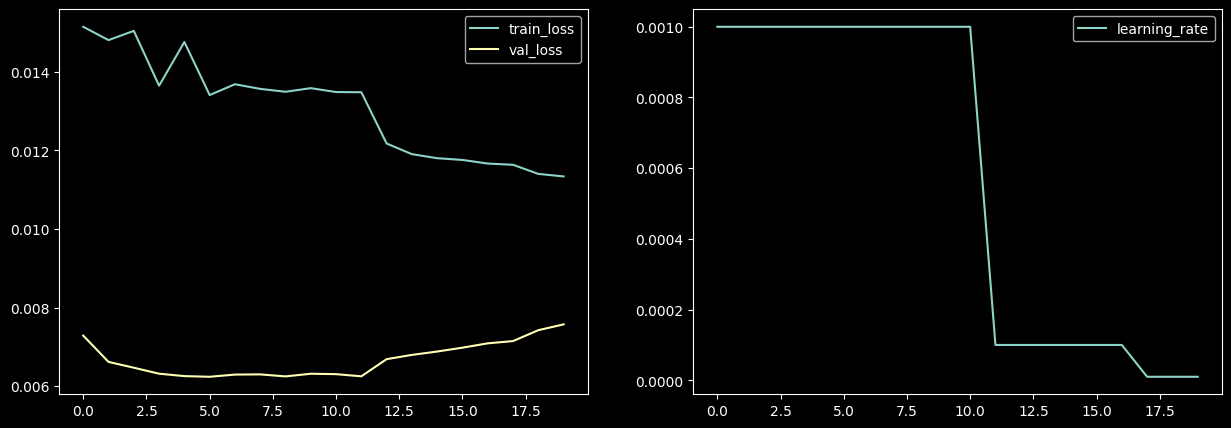

In [256]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_loss)
ax1.plot(val_loss)
ax1.legend(['train_loss', 'val_loss'])

ax2.plot(lr_list)
ax2.legend(['learning_rate'])

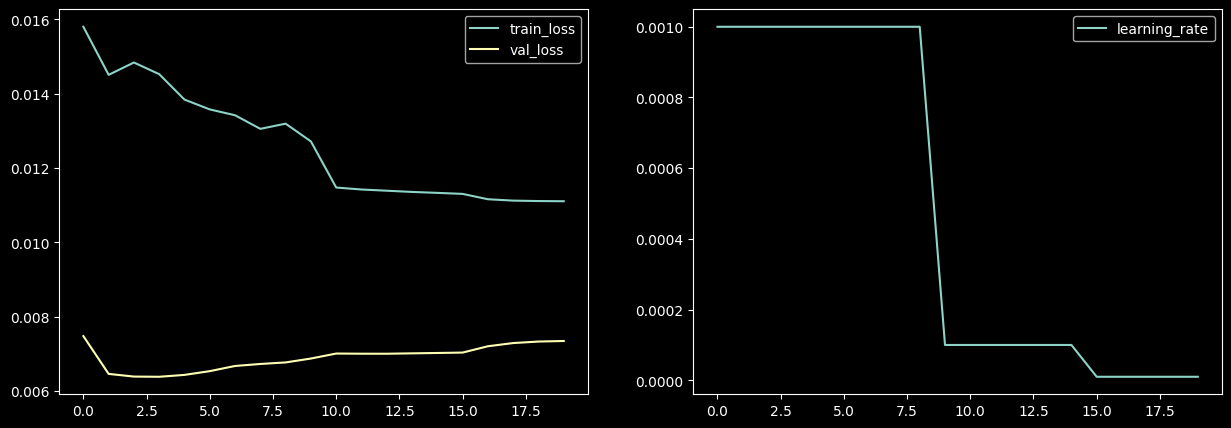

In [227]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_loss)
ax1.plot(val_loss)
ax1.legend(['train_loss', 'val_loss'])

ax2.plot(lr_list)
ax2.legend(['learning_rate'])

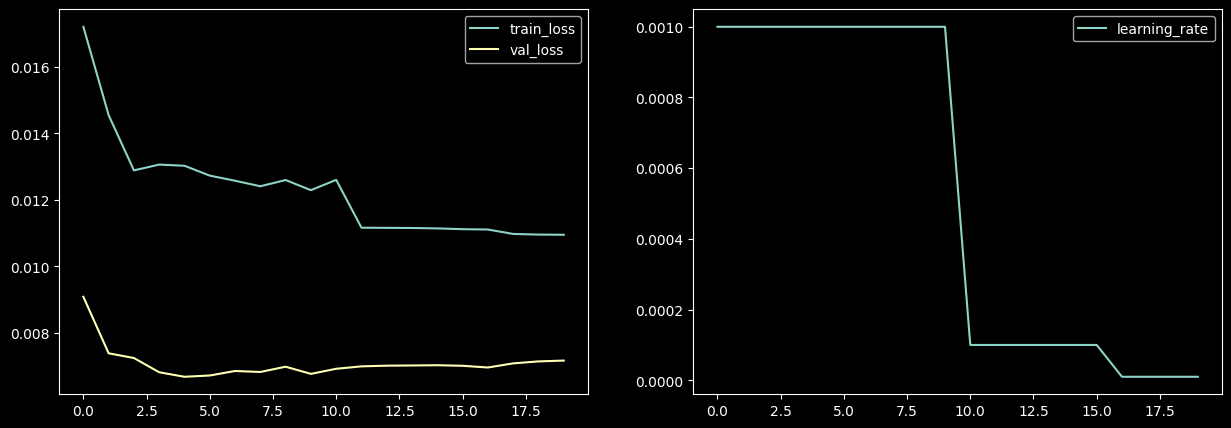

In [217]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_loss)
ax1.plot(val_loss)
ax1.legend(['train_loss', 'val_loss'])

ax2.plot(lr_list)
ax2.legend(['learning_rate'])

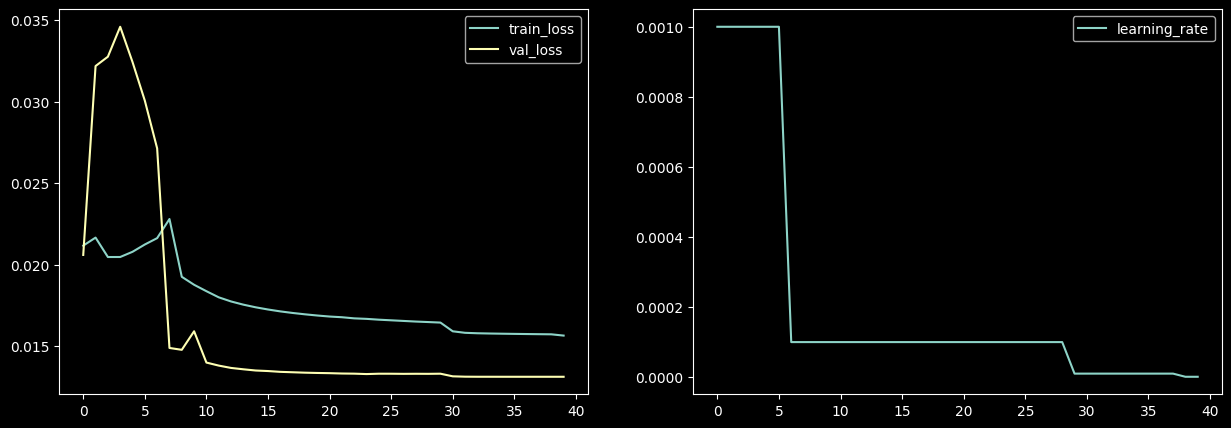

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_loss)
ax1.plot(val_loss)
ax1.legend(['train_loss', 'val_loss'])

ax2.plot(lr_list)
ax2.legend(['learning_rate'])

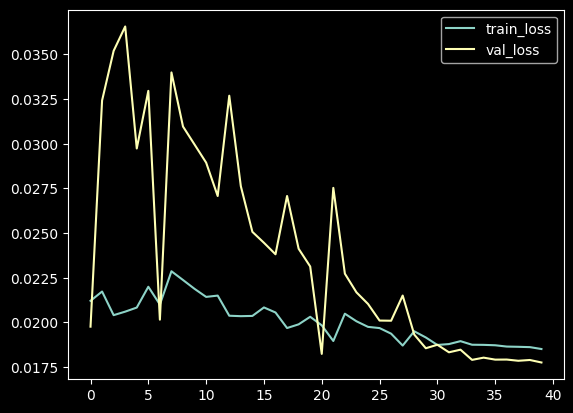

In [77]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])

# Проверка модели

In [257]:
y = []
y_pred = []

model.eval()
with torch.no_grad():
    running_test_loss = []
    true_answer = 0
    for x, targets, w in test_loader:
        x = x.reshape(16, seq_length*2).to(device)
        targets = targets.reshape(16, -1).to(device)

        pred = model(x)
        loss = loss_model(pred, targets, w).mean()

        running_test_loss.append(loss.item())
        mean_test_loss = sum(running_test_loss) / len(running_test_loss)

        y.extend(torch.squeeze(targets).tolist())
        y_pred.extend(torch.squeeze(pred).tolist())

    print(f'test_loss={mean_test_loss:.4f}')

test_loss=0.0031


In [258]:
y = train_dataset.scaler.inverse_transform(np.array(y).reshape(-1, 1))
y_pred = train_dataset.scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

ValueError: non-broadcastable output operand with shape (5904,1) doesn't match the broadcast shape (5904,2)

In [230]:
result = pd.DataFrame({'temp_ice': y.flatten(), 'pred_temp_ice': y_pred.flatten()})
result.head()

,temp_ice,pred_temp_ice
0,-0.9075,-0.127122
1,-0.9450,-0.122570
2,-0.9600,-0.053271
3,-0.9375,-0.002099
4,-0.9075,-0.042290


In [231]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [232]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(y=result['temp_ice'], name='Температура льда'), row=1, col=1)
fig.add_trace(go.Scatter(y=result['pred_temp_ice'], name='Прогноз'), row=1, col=1)
fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
                  legend=dict(orientation='h', yanchor='bottom', x=0, y=1.01),
                #   width=1000,
                  height=800,
                  font_color="#837A4F",
                  title_font_color="#837A4F")
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Температура: %{y:.2f}°C', row=1, col=1)
fig.update_yaxes(title_text='°C', row=1, col=1)